# Setup

## Repository and Libraries

In [1]:
if 'google.colab' in str(get_ipython()):
    # Move to the root
    import os
    os.chdir('/content')
    !git clone https://gitlab.com/jemaro/wut/neural-networks/style-transfer
    !cd style-transfer; git pull

In [2]:
if 'google.colab' in str(get_ipython()):
    # Move to the repository
    import os
    os.chdir('/content/style-transfer')

from style_transfer import Experiment, config_logger
from style_transfer.experiment import (
    DEFAULTS, CONTENT, STYLE, CONTENT_LAYERS, STYLE_LAYERS, PRE_TRAINING,
    LEARNING_RATE, BETA_1, BETA_2, EPSILON, AMSGRAD, CONTENT_WEIGHT, 
    STYLE_WEIGHT, NUM_ITERATIONS,
    )

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (25,25)
mpl.rcParams['axes.grid'] = False

from ipywidgets import (
    interact, fixed, Layout,
    Checkbox, SelectionSlider,
    )
from pathlib import Path
from math import log

logger = config_logger()

## Select experiment

style_transfer [INFO]: num_iterationss = [1000]


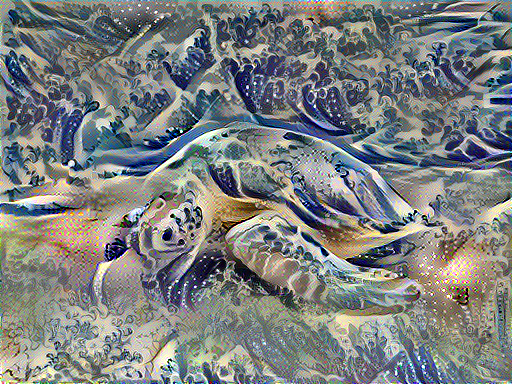

In [3]:
folder = Path('results', 'parameters_experiments')
exp = Experiment(folder)

logger.info(f'{NUM_ITERATIONS}s = {exp.options(NUM_ITERATIONS, **DEFAULTS)}')
exp.image(**DEFAULTS)

## Interactive tool

In [4]:
%%capture
# Styling
def layout(visible):
    return Layout(
        width='100%', max_width='800px', height='20px',
        visibility='visible' if visible else 'hidden',
        )
s = {'description_width': '100px'}

# Initialize the widgets
widgets = {}
for p, v in DEFAULTS.items():
    o = exp.options(p, **DEFAULTS)
    visible = len(o)>1
    if p in [PRE_TRAINING, AMSGRAD]:
        widgets[p] = Checkbox(
            value=v, layout=layout(visible), style=s,
            )
    else:
        widgets[p] = SelectionSlider(
            value=v, options=o, continuous_update=False, layout=layout(visible),
            style={**s, **({} if visible else {'handle_color': 'lightblue'})}, 
            )

# Dynamically change the ranges on new values
def update_ranges(*args):
    kwargs = {k: w.value for k, w in widgets.items()}
    for p, w in widgets.items():
        w.unobserve(update_ranges, 'value')
        o = exp.options(p, **kwargs)
        visible = len(o)>1
        if p not in [PRE_TRAINING, AMSGRAD]:
            w.options = o
            w.value = kwargs[p]
        w.layout = layout(visible)
        w.observe(update_ranges, 'value')
for w in widgets.values():
    w.observe(update_ranges, 'value')

# Plot function on change
def replot(**kwargs):
    # Image plot
    ax_im.imshow(exp.image(**kwargs))
    # Loss plot
    ax_it.clear()
    exp.loss_plot(**kwargs, ax=ax_it)
    ax_it.set_yscale('log')
    ratio = 1.8
    xvals = (0, 1000)
    ax_it.set_xlim(xvals)
    yvals = ax_it.get_ylim()
    _xrange = xvals[1]-xvals[0]
    _yrange = log(yvals[1])-log(yvals[0])
    ax_it.set_aspect(ratio*(_xrange/_yrange), adjustable='box')
    # Draw everything
    fig.canvas.draw()
    display(fig)
    return

# Initialize plots
fig = plt.figure()
ax_im = fig.add_subplot(1,2,1) 
ax_im.imshow(exp.image(**DEFAULTS))
plt.axis('off')
ax_it = fig.add_subplot(1,2,2) 

# Playground

In [5]:
interact(replot, **widgets)
print('Style Transfer')

interactive(children=(SelectionSlider(continuous_update=False, description='content_path', layout=Layout(heigh…

Style Transfer
